# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, make_scorer, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import json

import matplotlib.pyplot as plt


### Step 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent? 

##### Data has total of _42_ marketing campaigns
`df['campaign'].value_counts().count()`

### Step 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
print (f"Data has total of {df['campaign'].value_counts().count()} marketing campaigns")

Data has total of 42 marketing campaigns


In [4]:
df.sample(30)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
3512,32,services,married,high.school,unknown,yes,no,telephone,may,thu,...,3,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
4455,38,technician,married,professional.course,no,unknown,unknown,telephone,may,tue,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no
35498,47,management,married,high.school,no,no,no,cellular,may,mon,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,no
8641,32,blue-collar,married,basic.4y,unknown,yes,no,telephone,jun,wed,...,8,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,no
17811,47,admin.,married,high.school,no,yes,no,cellular,jul,tue,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,no
15999,48,technician,single,high.school,no,no,yes,cellular,jul,tue,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,no
28077,31,admin.,married,university.degree,no,no,no,cellular,apr,fri,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.479,5099.1,no
28058,24,technician,single,university.degree,no,yes,no,cellular,apr,fri,...,3,999,0,nonexistent,-1.8,93.075,-47.1,1.479,5099.1,no
26076,33,technician,married,university.degree,no,no,no,telephone,nov,wed,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,no
10008,42,blue-collar,married,basic.6y,no,no,no,telephone,jun,wed,...,7,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no


In [5]:
df.shape

(41188, 21)

### Step 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

#### Check the unique values of categorical fields 

In [7]:
categorical_columns = df.select_dtypes(include='object').columns.tolist()

print(categorical_columns)

for col in categorical_columns:
    print(f"Unique values in column '{col}':")
    print(df[col].value_counts())
    print("-" * 40)


['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
Unique values in column 'job':
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64
----------------------------------------
Unique values in column 'marital':
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64
----------------------------------------
Unique values in column 'education':
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64
---------------------

### Step 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

Increase efficiency of directed campaigns for long-term deposit subscriptions by reducing the number of contacts to do


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Step 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [ ]:
# For Categorical Data replace strings with numbers
df['education'] = df['education'].replace({'basic.4y':4, 'basic.6y':6, 'basic.9y':9, 'high.school':12, 'illiterate':0, 'professional.course':20, 'university.degree':16, 'unknown':-1}).astype('int8')
df['month'] = df['month'].replace({'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}).astype('int8')
df['day_of_week'] = df['day_of_week'].replace({'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5}).astype('int8')
df['poutcome'] = df['poutcome'].replace({'failure':0, 'nonexistent':1, 'success':2}).astype('int8')
df['y'] = df['y'].replace({'no':0, 'yes':1}).astype('int8')

# Replace unknown education with mean education. (The mean education is 12 years.)
df_non_negative_education = df[df['education'] > -1]
unk = df_non_negative_education['education'].mean()
df['education'] = df['education'].replace({-1:unk}).astype('int8')
del df_non_negative_education

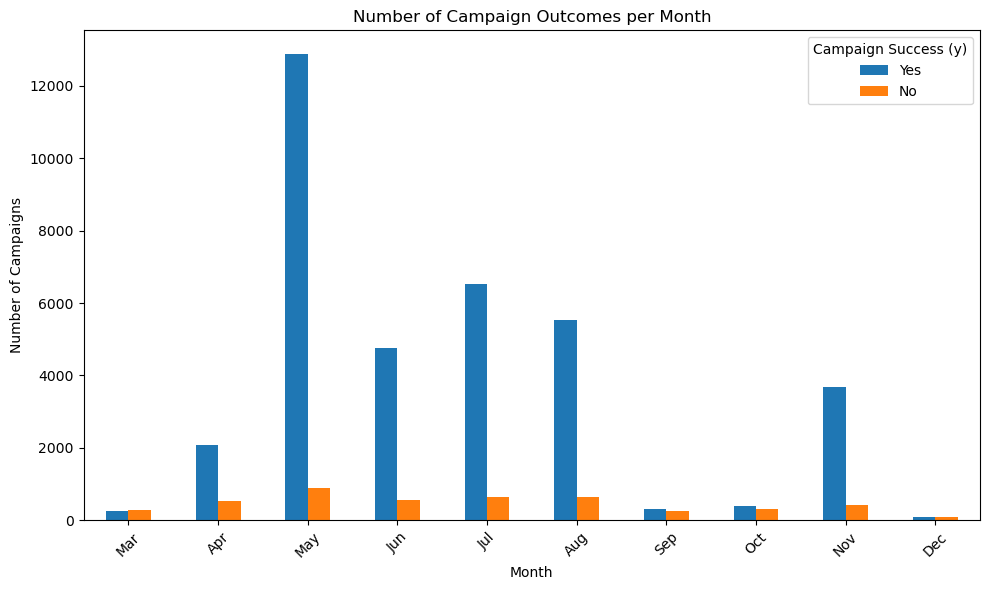

In [ ]:
import calendar

# Count number of campaigns per month grouped by 'y'
campaigns_per_month = df.groupby(['month', 'y']).size().unstack(fill_value=0)

# df["y"].sample(10)

# campaigns_per_month = df[df['y'] == "yes"].groupby(['month']).size()

# Ensure month is numeric; if string, map to numeric
month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
             'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

if campaigns_per_month.index.dtype == object:
    campaigns_per_month.index = campaigns_per_month.index.map(month_map)

# Sort by numeric month
campaigns_per_month = campaigns_per_month.sort_index()

# Map numeric month to abbreviated month names
month_names = [calendar.month_abbr[m] for m in campaigns_per_month.index]

# Make index a categorical with the correct calendar order
campaigns_per_month.index = pd.Categorical(month_names, categories=month_names, ordered=True)

# Plot grouped bar chart
campaigns_per_month.plot(kind='bar', stacked=False, figsize=(10,6))
plt.xlabel('Month')
plt.ylabel('Number of Campaigns')
plt.title('Number of Campaign Outcomes per Month')
plt.xticks(rotation=45)
plt.legend(['Yes', 'No'], title='Campaign Success (y)')
plt.tight_layout()
# plt.savefig('images/campaigns_per_month.png')
plt.show()



/var/folders/2f/6_4hcwj934j6nmv5h4kjmt9m0000gn/T/ipykernel_47824/2101999414.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_campaign = df.groupby(['age_group', 'y']).size().unstack(fill_value=0)


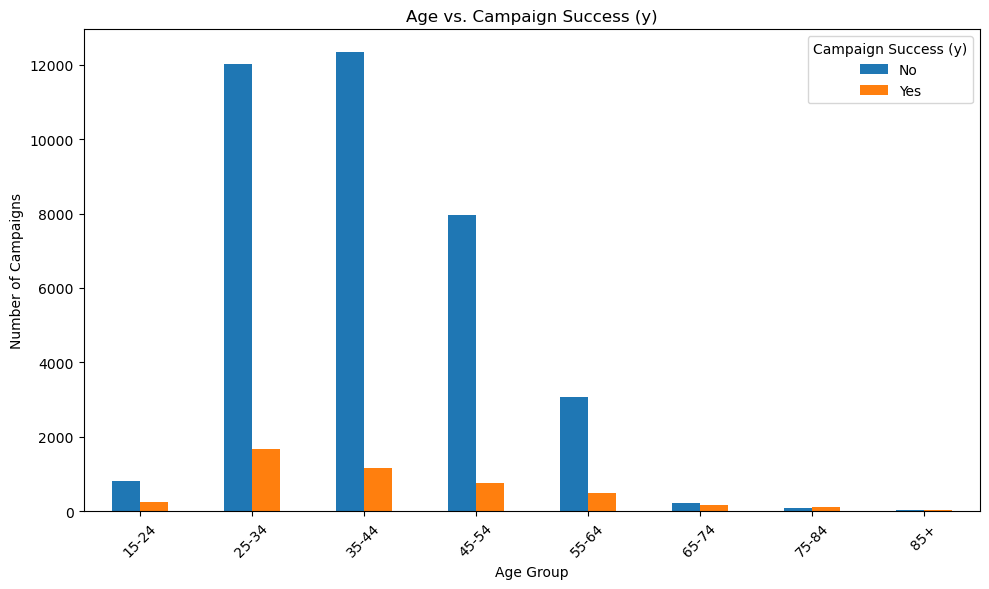

In [28]:

# Plot chart for age vs. those who accepted the campaign

import matplotlib.pyplot as plt

# Create bins for age groups (e.g., 10-year bins)
age_bins = [15, 25, 35, 45, 55, 65, 75, 85, 95]
age_labels = ['15-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

# Group by age group and campaign success
age_campaign = df.groupby(['age_group', 'y']).size().unstack(fill_value=0)

# Plot grouped bar chart
age_campaign.plot(kind='bar', stacked=False, figsize=(10,6))
plt.xlabel('Age Group')
plt.ylabel('Number of Campaigns')
plt.title('Age vs. Campaign Success (y)')
plt.xticks(rotation=45)
plt.legend(['No', 'Yes'], title='Campaign Success (y)')
plt.tight_layout()
# plt.savefig('images/age_vs_campaign_success.png')
plt.show()



/var/folders/2f/6_4hcwj934j6nmv5h4kjmt9m0000gn/T/ipykernel_47824/303219038.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_campaign = df.groupby(['duration_bin', 'y']).size().unstack(fill_value=0)


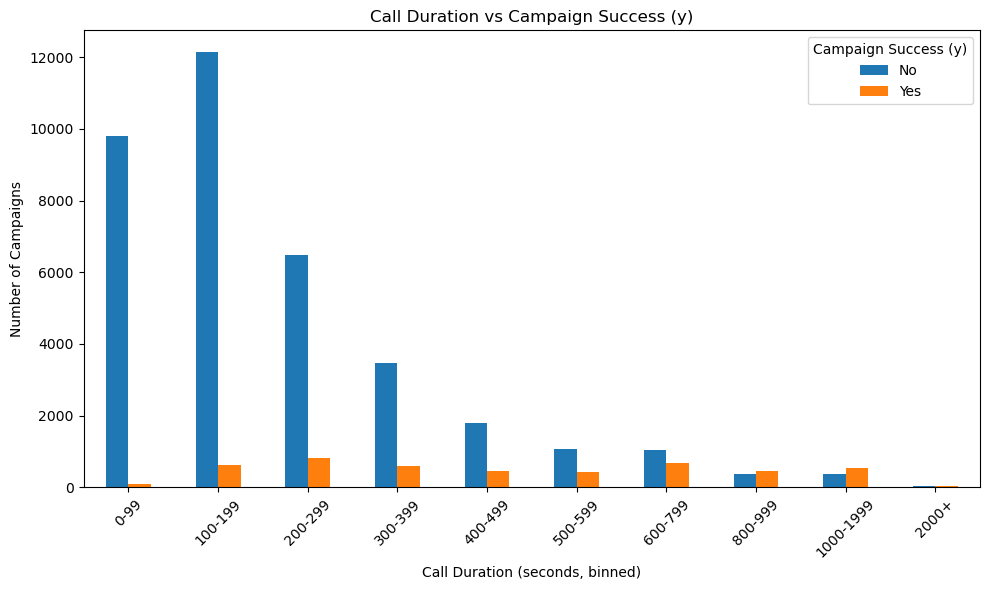

In [68]:
# Plot chart to show duration vs campaign which were successful

import matplotlib.pyplot as plt

# Create bins for call duration
duration_bins = [0, 100, 200, 300, 400, 500, 600, 800, 1000, 2000, 4000]
duration_labels = ['0-99', '100-199', '200-299', '300-399', '400-499', '500-599', '600-799', '800-999', '1000-1999', '2000+']

# Add a binned duration column
df['duration_bin'] = pd.cut(df['duration'], bins=duration_bins, labels=duration_labels, right=False, include_lowest=True)

# Group by duration bin and campaign success
duration_campaign = df.groupby(['duration_bin', 'y']).size().unstack(fill_value=0)

# Plot grouped bar chart
duration_campaign.plot(kind='bar', stacked=False, figsize=(10,6))
plt.xlabel('Call Duration (seconds, binned)')
plt.ylabel('Number of Campaigns')
plt.title('Call Duration vs Campaign Success (y)')
plt.xticks(rotation=45)
plt.legend(['No', 'Yes'], title='Campaign Success (y)')
plt.tight_layout()
# plt.savefig('images/duration_vs_successful_campaigns.png')
plt.show()


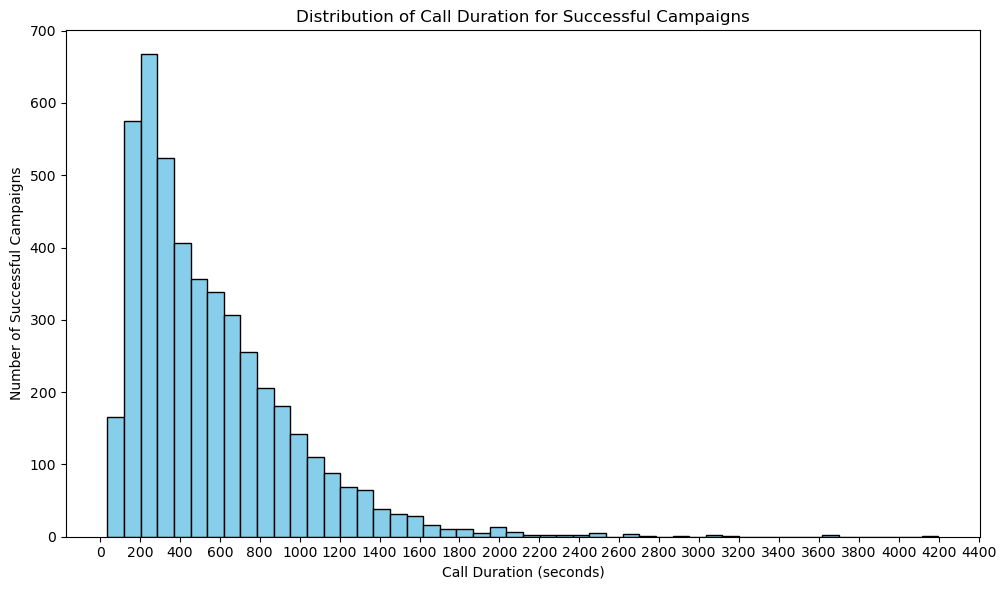

In [65]:
# Plot histogram to show duration vs campaign which were successful

import matplotlib.ticker as ticker
# Filter for successful campaigns
successful_campaigns = df[df['y'] == 1]

plt.figure(figsize=(10,6))
plt.hist(successful_campaigns['duration'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Call Duration (seconds)')
plt.ylabel('Number of Successful Campaigns')
plt.title('Distribution of Call Duration for Successful Campaigns')
plt.tight_layout()
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(200))
plt.savefig('images/duration_vs_successful_campaigns.png')
plt.show()


In [12]:
categorical_columns = df.select_dtypes(include='object').columns.tolist()

print(categorical_columns)

for col in categorical_columns:
    print(f"Unique values in column '{col}':")
    print(df[col].value_counts())
    print("-" * 40)

['job', 'marital', 'default', 'housing', 'loan', 'contact']
Unique values in column 'job':
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64
----------------------------------------
Unique values in column 'marital':
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64
----------------------------------------
Unique values in column 'default':
default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64
----------------------------------------
Unique values in column 'housing':
housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64
----------------------------------------
Unique values in column 'loan':
loan
no         33950
yes 

In [13]:
df["contact"].value_counts()

contact
cellular     26144
telephone    15044
Name: count, dtype: int64

In [14]:

# One-hot encode categorical features, keep age as is
X_encoded = pd.get_dummies(df, columns=['contact', 'job', 'marital', 'default', 'housing', 'loan'], drop_first=True)

print(X_encoded.columns.tolist())

X_encoded.drop(['job_unknown', 'marital_unknown', 'default_unknown', 'housing_unknown', 'loan_unknown'], axis=1, inplace=True)
X_encoded.reset_index(drop=True, inplace=True)

# Show the first few rows to verify
X_encoded.head()


['age', 'education', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'contact_telephone', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_married', 'marital_single', 'marital_unknown', 'default_unknown', 'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes']


,age,education,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,...,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,default_yes,housing_yes,loan_yes
0,56,4,5,1,261,1,999,0,1,1.1,...,False,False,False,False,False,True,False,False,False,False
1,57,12,5,1,149,1,999,0,1,1.1,...,False,True,False,False,False,True,False,False,False,False
2,37,12,5,1,226,1,999,0,1,1.1,...,False,True,False,False,False,True,False,False,True,False
3,40,6,5,1,151,1,999,0,1,1.1,...,False,False,False,False,False,True,False,False,False,False
4,56,12,5,1,307,1,999,0,1,1.1,...,False,True,False,False,False,True,False,False,False,True


In [15]:
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                41188 non-null  int64  
 1   education          41188 non-null  int8   
 2   month              41188 non-null  int8   
 3   day_of_week        41188 non-null  int8   
 4   duration           41188 non-null  int64  
 5   campaign           41188 non-null  int64  
 6   pdays              41188 non-null  int64  
 7   previous           41188 non-null  int64  
 8   poutcome           41188 non-null  int8   
 9   emp.var.rate       41188 non-null  float64
 10  cons.price.idx     41188 non-null  float64
 11  cons.conf.idx      41188 non-null  float64
 12  euribor3m          41188 non-null  float64
 13  nr.employed        41188 non-null  float64
 14  y                  41188 non-null  int8   
 15  contact_telephone  41188 non-null  bool   
 16  job_blue-collar    411

In [16]:
print (f"Total rows before dropping duplicates: {len(X_encoded)}")
X_encoded = X_encoded.drop_duplicates()
print (f"Total rows after dropping duplicates: {len(X_encoded)}")

Total rows before dropping duplicates: 41188
Total rows after dropping duplicates: 41174


### Step 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [17]:

X = X_encoded.drop('y', axis=1)
y = X_encoded['y']
# Split the data into train and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Show the shape of the splits to verify
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (32939, 30) (32939,)
Test shape: (8235, 30) (8235,)


### Step 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [18]:
# The baseline is the accuracy we'd get by always predicting the most frequent class.
# Find the most frequent class in the training set
most_frequent_class = y_train.value_counts().idxmax()
print(f"Most frequent class: {most_frequent_class}")
baseline_accuracy = (y_test == most_frequent_class).mean()

print(f"Baseline accuracy (majority class '{most_frequent_class}'): {baseline_accuracy:.4f}")


Most frequent class: 0
Baseline accuracy (majority class '0'): 0.8873


### Step 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [19]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Step 9: Score the Model

What is the accuracy of your model?

In [20]:
train_score = logreg.score(X_train, y_train)
print(f"Logistic Regression Train Score: {train_score:.5f}")
test_score = logreg.score(X_test, y_test)
print(f"Logistic Regression Test Score: {test_score:.5f}")


Logistic Regression Train Score: 0.90959
Logistic Regression Test Score: 0.90601


### Step 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [21]:
results_df = pd.DataFrame(columns=['model','train time', 'train score', 'test score', 'precision', 'recall'])
model_list = [ LogisticRegression(max_iter=5000),  KNeighborsClassifier(),  DecisionTreeClassifier(),  SVC()]

for model in model_list:
    start_time = time.time()
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    end_time = time.time()
    train_time = end_time - start_time
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)   
    results_df.loc[model.__class__.__name__, 'model'] = model.__class__.__name__
    results_df.loc[model.__class__.__name__, 'train time'] = train_time
    results_df.loc[model.__class__.__name__, 'train score'] = train_score
    results_df.loc[model.__class__.__name__, 'test score'] = test_score
    results_df.loc[model.__class__.__name__, 'precision'] = precision
    results_df.loc[model.__class__.__name__, 'recall'] = recall

results_df  

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model,train time,train score,test score,precision,recall
LogisticRegression,LogisticRegression,12.180665,0.910805,0.908197,0.646758,0.408405
KNeighborsClassifier,KNeighborsClassifier,0.929568,0.932967,0.900425,0.565693,0.501078
DecisionTreeClassifier,DecisionTreeClassifier,0.103198,1.0,0.889253,0.508282,0.529095
SVC,SVC,11.1141,0.898327,0.895932,0.612698,0.207974


### Hyperparameter Tuning using GridSearchCV

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [22]:
# Let's perform hyperparameter tuning for KNN, LogisticRegression and Decision Tree using GridSearchCV.

# Define parameter grids

logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [5000]
}

knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

dt_param_grid = {
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 5],
    'criterion': ['entropy']
}

# Define parameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

results_hyperparameter_tuning = pd.DataFrame(columns=['model','best_accuracy_from_cv', 'best_precision_from_cv', 'best_recall_from_cv', 'best_params'])

model_list = [ KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression()]

param_grid_map = {
    'LogisticRegression': logreg_param_grid,
    'KNeighborsClassifier': knn_param_grid,
    'DecisionTreeClassifier': dt_param_grid,
    'SVC': svm_param_grid
}

scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f1': make_scorer(f1_score, average='macro', zero_division=0)
}

for model in model_list:
    grid = GridSearchCV(model, param_grid_map[model.__class__.__name__], cv=3, refit='precision', scoring=scoring_metrics, n_jobs=1)
    grid.fit(X_train, y_train)
    best_index = grid.best_index_
    results_hyperparameter_tuning.loc[model.__class__.__name__, 'model'] = model.__class__.__name__
    results_hyperparameter_tuning.loc[model.__class__.__name__, 'best_accuracy_from_cv'] = grid.cv_results_['mean_test_accuracy'][best_index].round(4)
    results_hyperparameter_tuning.loc[model.__class__.__name__, 'best_precision_from_cv'] = grid.cv_results_['mean_test_precision'][best_index].round(4)
    results_hyperparameter_tuning.loc[model.__class__.__name__, 'best_recall_from_cv'] = grid.cv_results_['mean_test_recall'][best_index].round(4)
    results_hyperparameter_tuning.loc[model.__class__.__name__, 'best_params'] = json.dumps(grid.best_params_)

results_hyperparameter_tuning

,model,best_accuracy_from_cv,best_precision_from_cv,best_recall_from_cv,best_params
KNeighborsClassifier,KNeighborsClassifier,0.9075,0.7744,0.7253,"{""n_neighbors"": 7, ""weights"": ""uniform""}"
DecisionTreeClassifier,DecisionTreeClassifier,0.9124,0.7909,0.7345,"{""criterion"": ""entropy"", ""max_depth"": 5, ""min_..."
LogisticRegression,LogisticRegression,0.9107,0.8012,0.6886,"{""C"": 0.1, ""max_iter"": 5000, ""penalty"": ""l1"", ..."



#### SVM

In [23]:
# This is way to slow, its more than 30 minutes and still running.
# grid = GridSearchCV(SVC(), svm_param_grid, cv=3, refit='precision', scoring=scoring_metrics, n_jobs=1)
# grid.fit(X_train, y_train)
# best_index = grid.best_index_
# results_hyperparameter_tuning.loc[model.__class__.__name__, 'model'] = model.__class__.__name__
# results_hyperparameter_tuning.loc[model.__class__.__name__, 'best_accuracy_from_cv'] = grid.cv_results_['mean_test_accuracy'][best_index].round(4)
# results_hyperparameter_tuning.loc[model.__class__.__name__, 'best_precision_from_cv'] = grid.cv_results_['mean_test_precision'][best_index].round(4)
# results_hyperparameter_tuning.loc[model.__class__.__name__, 'best_recall_from_cv'] = grid.cv_results_['mean_test_recall'][best_index].round(4)
# results_hyperparameter_tuning.loc[model.__class__.__name__, 'best_params'] = str(grid.best_params_)

# results_hyperparameter_tuning

In [24]:
# Processing SVC using pipeline with StandardScaler and GridSearchCV

# Create a pipeline with StandardScaler and SVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

svm_param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['scale', 'auto']
}

grid = GridSearchCV(pipeline, svm_param_grid, cv=3, refit='precision', scoring=scoring_metrics, n_jobs=1)
grid.fit(X_train, y_train)
best_index = grid.best_index_
results_hyperparameter_tuning.loc['SVM', 'model'] = 'SVM'
results_hyperparameter_tuning.loc['SVM', 'best_accuracy_from_cv'] = grid.cv_results_['mean_test_accuracy'][best_index].round(4)
results_hyperparameter_tuning.loc['SVM', 'best_precision_from_cv'] = grid.cv_results_['mean_test_precision'][best_index].round(4)
results_hyperparameter_tuning.loc['SVM', 'best_recall_from_cv'] = grid.cv_results_['mean_test_recall'][best_index].round(4)
results_hyperparameter_tuning.loc['SVM', 'best_params'] = json.dumps(grid.best_params_)


In [25]:
results_hyperparameter_tuning

,model,best_accuracy_from_cv,best_precision_from_cv,best_recall_from_cv,best_params
KNeighborsClassifier,KNeighborsClassifier,0.9075,0.7744,0.7253,"{""n_neighbors"": 7, ""weights"": ""uniform""}"
DecisionTreeClassifier,DecisionTreeClassifier,0.9124,0.7909,0.7345,"{""criterion"": ""entropy"", ""max_depth"": 5, ""min_..."
LogisticRegression,LogisticRegression,0.9107,0.8012,0.6886,"{""C"": 0.1, ""max_iter"": 5000, ""penalty"": ""l1"", ..."
SVM,SVM,0.9003,0.7961,0.6013,"{""svc__C"": 0.1, ""svc__gamma"": ""scale"", ""svc__k..."


#### Findings
##### _Among the 4 classifier <u>LogisticRegression</u> has best accuracy with better precision and recall score_

